<a href="https://colab.research.google.com/github/jvrjsanchez/EFIA/blob/main/Projeto3_SA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Engenharia Financeira com Inteligência Artificial</font>
## <font color='blue'>Projeto 3</font>
## <font color='blue'>Portfólio de Investimento com Fronteira Eficiente e Otimização Matemática</font>

## Instalando e Carregando Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
# Instala o pacote
#!pip install -q yfinance

In [3]:
# Imports
import scipy
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

In [4]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Definindo os Ativos Financeiros Para o Portfólio

In [5]:
# Define os assets e faz o download dos dados
df_dsa = yf.download(['NU',
                      'CRM',
                      'SNOW',
                      'QUBT',
                      'SOFI',
                      'HUBS',
                      'AMD',
                      'YELP',
                      'TSM'],
                     start = '2025-06-01', end = '2025-09-29')

[*********************100%***********************]  9 of 9 completed


In [6]:
# Separa a coluna com o valor de fechamento
df_dsa = df_dsa['Close']

In [7]:
# Shape
df_dsa.shape

(82, 9)

In [8]:
# Amostra dos dados
df_dsa.head()

Ticker,AMD,CRM,HUBS,NU,QUBT,SNOW,SOFI,TSM,YELP
Date,,,,,,,,,
2025-06-02,114.629997,260.751740,592.020020,12.00,11.80,210.169998,13.67,193.519638,37.150002
2025-06-03,117.309998,263.592285,600.109985,11.99,12.40,209.149994,13.66,196.270889,37.500000
2025-06-04,118.580002,262.296631,599.289978,11.94,12.83,209.600006,13.46,201.028412,37.450001
2025-06-05,115.690002,266.253418,602.609985,12.11,11.83,210.100006,13.67,201.962051,36.799999
2025-06-06,116.190002,273.598969,609.400024,12.15,13.70,210.839996,14.24,203.789581,37.000000


## Calculando a Variação Percentual

In [9]:
# Calcula os retornos
retornos = df_dsa.pct_change()

O método pct_change() calcula a variação percentual entre o elemento atual e o anterior em cada coluna. Por padrão, o cálculo é feito linha a linha (ou seja, ao longo do eixo 0). O primeiro elemento de cada coluna resulta em NaN (Not a Number), pois não há um valor anterior para calcular a variação percentual.

No contexto de análise financeira, essa operação é frequentemente usada para calcular os retornos diários, mensais ou anuais de ativos, como ações ou criptomoedas, a partir de seus preços históricos. Os retornos calculados são úteis para várias análises, incluindo avaliação de desempenho de investimentos, modelagem de risco e otimização de portfólios.

In [10]:
# Drop de valores na
retornos = retornos.dropna()

In [11]:
retornos.tail()

Ticker,AMD,CRM,HUBS,NU,QUBT,SNOW,SOFI,TSM,YELP
Date,,,,,,,,,
2025-09-22,0.015249,0.010523,0.007960,0.008040,-0.131500,-0.004078,0.010166,0.029297,-0.002828
2025-09-23,0.006947,-0.020545,-0.018796,-0.009202,0.059129,-0.026139,-0.024153,0.036973,-0.011342
2025-09-24,-0.000124,0.005438,0.004307,-0.008669,0.000234,-0.004339,-0.022344,-0.007074,0.001912
2025-09-25,0.002424,-0.020090,-0.016823,-0.014366,-0.038767,-0.004358,-0.011252,-0.014428,-0.004453
2025-09-26,-0.011223,0.010293,0.021868,0.000000,-0.021137,0.013718,-0.004979,-0.011928,0.005751


In [12]:
# Calcula a média
media_retornos = retornos.mean()

In [13]:
print("Média do Retornos Percentuais:")
print(media_retornos)

Média do Retornos Percentuais:
Ticker
AMD     0.004447
CRM    -0.000712
HUBS   -0.001397
NU      0.003686
QUBT    0.009052
SNOW    0.001250
SOFI    0.009310
TSM     0.004437
YELP   -0.001894
dtype: float64


## Simulando Diferentes Combinações de Pesos Para os Ativos do Portfólio

In [14]:
# Define a semente aleatória para garantir a reprodutibilidade dos resultados
np.random.seed(42)

In [15]:
# Define o número de portfólios a serem simulados
num_ports = 10000

In [16]:
# Inicializa uma matriz para armazenar os pesos de cada ativo nos portfólios
all_pesos = np.zeros((num_ports, 9))

In [17]:
# Inicializa um array para armazenar os retornos esperados de cada portfólio
ret_arr = np.zeros(num_ports)

In [18]:
# Inicializa um array para armazenar a volatilidade (risco) de cada portfólio
vol_arr = np.zeros(num_ports)

In [19]:
# Inicializa um array para armazenar a relação Sharpe de cada portfólio
sharpe_arr = np.zeros(num_ports)

In [20]:
# Calcula a matriz de covariância
cov_matrix = retornos.cov()

Uma matriz de covariância é uma ferramenta estatística que mede a covariância (ou seja, a medida de como duas variáveis mudam conjuntamente) entre pares de variáveis em um conjunto de dados. Em outras palavras, ela ajuda a entender como duas variáveis se movem em relação uma à outra. No contexto de finanças, por exemplo, é frequentemente usada para analisar como os retornos de diferentes ativos se movem juntos, o que é fundamental para a diversificação e gestão de risco de portfólios de investimento.

## Calculando Retorno Esperado, Volatilidade e Índice de Sharpe

In [21]:
# Loop para calcular retorno esperado, volatilidade esperada e Sharpe Ratio
for x in range(num_ports):

    # Define os pesos
    pesos = np.array(np.random.random(9))
    pesos = pesos / np.sum(pesos)

    # Salva os pesos
    all_pesos[x,:] = pesos

    # Retorno esperado
    ret_arr[x] = np.sum((media_retornos * pesos * len(retornos)))

    # Volatilidade esperada
    vol_arr[x] = np.sqrt(np.dot(pesos.T, np.dot(cov_matrix * len(retornos), pesos)))

    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x] / vol_arr[x]

O loop acima itera por um número definido de portfólios (num_ports), simulando diferentes combinações de pesos para os ativos de cada portfólio, calculando e armazenando suas características principais: retorno esperado, volatilidade e relação Sharpe.

Para cada portfólio (x) dentre o total especificado (num_ports), realiza os seguintes passos:

**Geração de Pesos**: Gera um conjunto aleatório de pesos para 10 ativos em um portfólio. Esses pesos são normalizados para que a soma seja 1, garantindo que o total investido seja distribuído proporcionalmente entre os 10 ativos.

**Armazenamento de Pesos**: Salva os pesos gerados na matriz all_pesos, que mantém um registro dos pesos de cada ativo para cada simulação de portfólio.

**Cálculo do Retorno Esperado**: Calcula o retorno esperado do portfólio multiplicando os retornos médios de cada ativo (media_retornos) pelos pesos e pelo número de retorno (len(retornos)). O resultado é armazenado em ret_arr.

**Cálculo da Volatilidade Esperada**: Utiliza a matriz de covariância dos retornos dos ativos (retornos.cov()) para calcular a volatilidade esperada do portfólio. A matriz de covariância é ajustada pelo número de períodos de retorno e a volatilidade é calculada como a raiz quadrada da variância do portfólio, que é obtida através do produto matricial dos pesos pelo quadrado da matriz de covariância. O resultado é armazenado em vol_arr.

**Cálculo da Relação Sharpe**: Calcula a relação Sharpe para cada portfólio como o quociente entre seu retorno esperado e sua volatilidade. Este valor, armazenado em sharpe_arr, mede o retorno ajustado ao risco de cada portfólio, permitindo identificar aqueles que oferecem o melhor retorno por unidade de risco assumido.

## Interpretando o Sharpe Ratio Máximo

In [22]:
# 5 primeiras linhas de Pesos
all_pesos[:5]

array([[0.08335534, 0.21158512, 0.16290806, 0.13323374, 0.03472255,
        0.03471718, 0.01292673, 0.19277083, 0.13378045],
       [0.17982445, 0.00522771, 0.24632151, 0.21140988, 0.05392634,
        0.04617687, 0.04657801, 0.07726636, 0.13326887],
       [0.12085938, 0.0814867 , 0.17119808, 0.03903076, 0.08174286,
        0.10250903, 0.12760961, 0.21969434, 0.05586926],
       [0.10896795, 0.12553457, 0.00984299, 0.12874073, 0.03613462,
        0.01378464, 0.20107192, 0.20462056, 0.17130202],
       [0.09102797, 0.02918743, 0.20446989, 0.13153111, 0.03646878,
        0.1479741 , 0.01027635, 0.27173293, 0.07733142]])

In [23]:
# 5 primeiros Retornos
ret_arr[:5]

array([0.12664818, 0.18638802, 0.26805098, 0.2961161 , 0.18251233])

In [24]:
# 5 primeiros valores de Volatilidade
vol_arr[:5]

array([0.11647433, 0.1350743 , 0.13888456, 0.12856365, 0.12463915])

In [25]:
# 5 primeiros valores de Sharpe Ratio
sharpe_arr[:5]

array([1.08734842, 1.37989257, 1.93002723, 2.30326454, 1.46432581])

In [26]:
print("Sharpe Ratio Máximo:", sharpe_arr.max())

Sharpe Ratio Máximo: 2.7452255385219213


O valor de Sharpe Ratio Máximo indica que o melhor portfólio simulado, dentre as combinações testadas, oferece um retorno ajustado ao risco excepcionalmente alto.

A Relação Sharpe é uma métrica que avalia o desempenho ajustado ao risco de um investimento, comparando seu retorno em excesso (o retorno além da taxa livre de risco) com sua volatilidade.

Uma Relação Sharpe:

- Maior que 1 é considerada boa, indicando que o retorno em excesso do investimento compensa adequadamente pelo risco assumido.
- Maior que 2 é considerada muito boa, sugerindo que o investimento oferece um retorno em excesso significativamente maior por cada unidade de risco.
- Maior que 3 é considerada excepcional, indicando um investimento de alta performance em termos de retorno ajustado ao risco.

Assim, um valor acima coloca o portfólio no patamar de desempenho "muito bom", demonstrando que, para cada unidade de risco assumido, o portfólio gera um retorno substancialmente maior em comparação com portfólios de menor relação Sharpe.

Este é um indicativo de que a combinação de ativos deste portfólio específico, juntamente com a distribuição de seus pesos, foi otimizada de forma eficaz para maximizar o retorno ajustado ao risco. Investidores que buscam um equilíbrio entre risco e retorno podem considerar esse portfólio como uma opção atrativa, dada sua alta eficiência em termos de performance ajustada ao risco.

## Melhores Pesos Atribuídos a Cada Ativo Financeiro com Base no Sharpe Ratio

In [27]:
# Extrai o valor máximo
indice = sharpe_arr.argmax()

In [28]:
# Inicializa o contador
contador = 0

In [29]:
# Inicia um loop para iterar através da lista de símbolos de ações
for i in ('NU','CRM','SNOW','HUBS','AMD','QUBT','SOFI','YELP','TSM'):

    # Imprime o peso atribuído a cada símbolo de ação no portfólio, arredondando para 3 casas decimais
    print("Peso Atribuído a", i, ": ", round(all_pesos[indice,:][contador], 3))

    # Incrementa o contador para avançar para o próximo peso na lista de pesos do portfólio
    contador += 1

Peso Atribuído a NU :  0.245
Peso Atribuído a CRM :  0.027
Peso Atribuído a SNOW :  0.039
Peso Atribuído a HUBS :  0.039
Peso Atribuído a AMD :  0.075
Peso Atribuído a QUBT :  0.021
Peso Atribuído a SOFI :  0.285
Peso Atribuído a YELP :  0.248
Peso Atribuído a TSM :  0.02


## Gráfico de Retorno x Risco x Sharpe Ratio

In [30]:
# Extrai os valores máximos
max_sr_ret = ret_arr[indice]
max_sr_vol = vol_arr[indice]

In [31]:
max_sr_ret

np.float64(0.4519791135913652)

In [32]:
max_sr_vol

np.float64(0.16464188725080814)

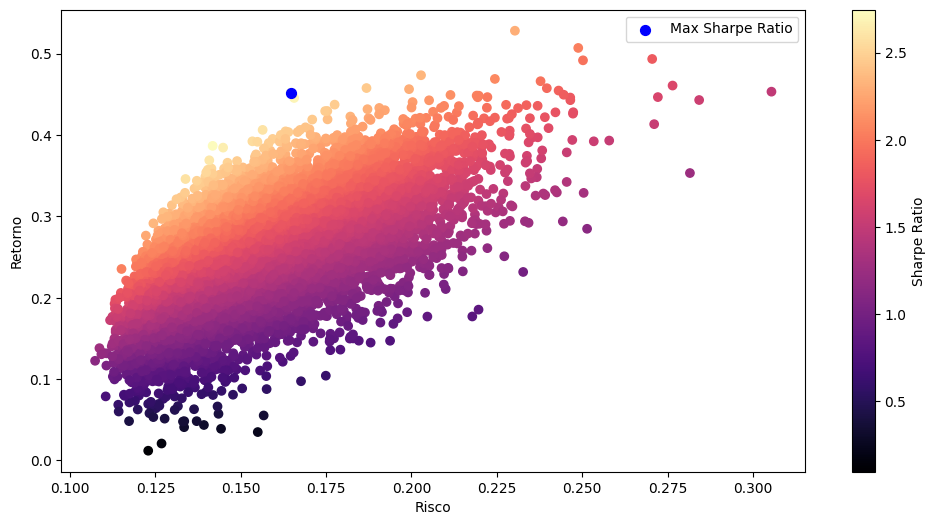

In [33]:
# Plot
plt.figure(figsize = (12,6))
plt.scatter(vol_arr, ret_arr, c = sharpe_arr, cmap = 'magma')
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.scatter(max_sr_vol, max_sr_ret, c = 'blue', s = 50, label = 'Max Sharpe Ratio')
plt.legend()
plt.show()

Fizemos o processo manualmente. Agora vamos automatizá-lo para encontrar os melhores valores de pesos que geram o maior valor de Sharpe Ratio.

## Teoria da Média-Variância Para Construir a Fronteira Eficiente

In [34]:
# Define uma função para calcular o retorno, volatilidade e relação Sharpe de um portfólio com base nos pesos
def dsa_get_ret_vol_sr(weights):

    # Converte os pesos de entrada para um array NumPy para facilitar cálculos matemáticos
    weights = np.array(weights)

    # Calcula o retorno esperado do portfólio, multiplicando os retornos médios dos ativos
    # pelos pesos e pelo número de períodos de retorno
    ret = np.sum(media_retornos * weights) * len(retornos)

    # Calcula a volatilidade do portfólio, que é a raiz quadrada do produto matricial dos pesos
    # pelo quadrado da matriz de covariância ajustada pelo número de períodos de retorno
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * len(retornos), weights)))

    # Calcula a relação Sharpe do portfólio, dividindo o retorno pelo nível de volatilidade
    sr = ret / vol

    # Retorna um array NumPy contendo o retorno esperado, volatilidade e relação Sharpe do portfólio
    return np.array([ret, vol, sr])

Para maximizar o índice de sharpe positivo, temos que minimizar o negativo do índice de sharpe porque a função de otimização funciona apenas no valor mínimo de uma função. Isso é essencialmente o que fazemos em qualquer modelo de IA.

In [35]:
# Define uma função para calcular o negativo da relação Sharpe de um portfólio,
# que é usada como função objetivo em processos de otimização
def dsa_neg_sharpe(weights):

    # Chama a função get_ret_vol_sr para os pesos fornecidos,
    # obtém a relação Sharpe (índice [2] do array retornado)
    # e multiplica por -1 para torná-la negativa
    return dsa_get_ret_vol_sr(weights)[2] * -1

In [36]:
# Define uma função para verificar se a soma dos pesos dos ativos em um portfólio é igual a 1,
# o que é uma restrição comum em otimização de portfólio
def dsa_check_sum(weights):

    # Retorna a diferença entre a soma dos pesos fornecidos e 1, o resultado deve ser 0 se os pesos
    # somarem exatamente 1
    return np.sum(weights) - 1

## Definindo as Restrições do Problema de Otimização

In [37]:
# Define uma restrição de igualdade para garantir que a soma dos pesos dos ativos no portfólio seja igual a 1
cons = ({'type': 'eq', 'fun': dsa_check_sum})

In [38]:
# Define os limites para cada peso do portfólio,
# estabelecendo que cada peso pode variar entre 0.0 (0%) e 1.0 (100%)
limite = (0.0, 1.0)

In [39]:
# Cria uma tupla de limites para cada um dos 10 ativos no portfólio, aplicando o limite definido acima a cada um
limites = tuple(limite for asset in range(9))

In [40]:
# Define um palpite inicial para os pesos dos ativos no portfólio, começando com 10% para cada um dos 10 ativos
init_guess = [0.1 for i in range(9)]

## Otimização com SLSQP (Sequential Least Squares Programming)

Veja a descrição de SLSQP no videobook do Capítulo 6.

In [41]:
# Utiliza a função minimize do cipy.optimizse para encontrar os pesos dos ativos que minimizam
# a negação da relação Sharpe, indicando a otimização do portfólio para o máximo retorno ajustado ao risco.
# Usa o método 'SLSQP' (Sequential Least Squares Programming), limites para cada peso do ativo
# e a restrição de que a soma dos pesos deve ser igual a 1.
resultado_otimizacao = minimize(dsa_neg_sharpe,
                                init_guess,
                                method = 'SLSQP',
                                bounds = limites,
                                constraints = cons)

In [42]:
print(resultado_otimizacao)

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: -3.1795921318851663
           x: [ 4.907e-02  0.000e+00  2.904e-16  3.070e-02  0.000e+00
                1.352e-16  4.737e-01  4.465e-01  1.146e-16]
         nit: 10
         jac: [ 1.441e-04  6.990e-01  1.060e+00  5.335e-05  7.389e-01
                8.134e-01  5.773e-04 -6.320e-04  1.467e+00]
        nfev: 101
        njev: 10
 multipliers: [ 2.780e-04]


Os resultados da otimização indicam um sucesso na busca pelos pesos ótimos dos ativos em um portfólio que maximiza a relação Sharpe, ajustando-se pelo risco. Aqui está o que cada elemento do resultado significa:

**message: "Optimization terminated successfully"** - A otimização terminou com sucesso, o que significa que o processo de otimização encontrou uma solução sem enfrentar erros significativos.

**success: True** - Confirma que a otimização foi bem-sucedida.

**status: 0** - Um código de status de 0 geralmente indica uma conclusão bem-sucedida do algoritmo de otimização.

**fun**: O valor da função objetivo (negativo da relação Sharpe) no ótimo encontrado. O valor negativo é usado por convenção na otimização para transformar um problema de maximização (maximizar a relação Sharpe) em minimização (minimizar o negativo da relação Sharpe). O valor real da relação Sharpe é o positivo deste número.

**x:** Array que mostra a distribuição de pesos ótimos para cada um dos 10 ativos no portfólio. Valores próximos a zero indicam que o ativo correspondente tem pouca ou nenhuma participação no portfólio otimizado.

**nit:** O número de iterações do algoritmo até encontrar a solução ótima.

**jac**: Array que mostra o gradiente da função objetivo (negativo da relação Sharpe) em relação aos pesos no ponto ótimo. Esses valores ajudam a entender a sensibilidade da relação Sharpe a mudanças nos pesos dos ativos próximos ao ótimo.

**nfev:** O número de avaliações da função objetivo que o algoritmo realizou. Isso dá uma ideia do esforço computacional envolvido.

**njev:** O número de avaliações do jacobiano (ou gradiente) da função objetivo, indicando quantas vezes o gradiente foi calculado durante a otimização.

Interpretando estes resultados, você pode concluir que a otimização foi bem-sucedida e resultou em um portfólio que maximiza a relação Sharpe, indicando um alto retorno ajustado ao risco. A distribuição de pesos sugere uma concentração do investimento em poucos ativos espcificamente, com os demais ativos recebendo pouca ou nenhuma alocação.

## Construção, Plot e Interpretação da Fronteira Eficiente

In [43]:
# Extraindo os valores de x (melhores pesos)
resultado_otimizacao.x

array([4.90740566e-02, 0.00000000e+00, 2.90385939e-16, 3.06967821e-02,
       0.00000000e+00, 1.35197797e-16, 4.73693621e-01, 4.46535540e-01,
       1.14582100e-16])

In [44]:
# Aplica a função e calcula retorno, volatilidade e sharpe ratio
dsa_get_ret_vol_sr(resultado_otimizacao.x)

array([0.5445352 , 0.17125945, 3.17959213])

In [45]:
# Define os valores para as coordenadas da fronteira em y
frontier_y = np.linspace(0.0, 0.60, num = 200)

In [46]:
# Função para retornar a volatilidade
def dsa_retorna_volatilidade(weights):
    return dsa_get_ret_vol_sr(weights)[1]

A função acima é definida para retornar a volatilidade do portfólio de investimentos, que é calculada com base nos pesos dos ativos dentro desse portfólio. Essa função utiliza outra função chamada dsa_get_ret_vol_sr(weights), que calcula três características importantes de um portfólio com base nos pesos dos ativos: o retorno esperado do portfólio ([0]), a volatilidade do portfólio ([1]) e a relação Sharpe do portfólio ([2]). A função dsa_minimize_volatility() é focada especificamente na volatilidade, por isso retorna o segundo elemento do array resultante da função dsa_get_ret_vol_sr, correspondente à volatilidade ([1]).

In [47]:
# Lista para os valores das coordenadas da fronteira em x
frontier_x = []

In [48]:
# Inicia um loop para iterar por uma lista de retornos esperados (frontier_y),
# que faz parte da construção da fronteira eficiente
for retorno_possivel in frontier_y:

    # Define restrições para a otimização: uma garante que a soma dos pesos seja 1 (check_sum)
    # e a outra garante que o retorno esperado do portfólio seja igual ao retorno possível atual na iteração
    cons = ({'type':'eq', 'fun': dsa_check_sum},
            {'type':'eq', 'fun': lambda w: dsa_get_ret_vol_sr(w)[0] - retorno_possivel})

    # Realiza a otimização para minimizar a volatilidade (risco) do portfólio sob as restrições definidas,
    # usando um palpite inicial (init_guess), método 'SLSQP', limites definidos para os pesos (bounds)
    # e as restrições (cons)
    resultado = minimize(dsa_retorna_volatilidade,
                         init_guess,method = 'SLSQP',
                         bounds = limites,
                         constraints = cons)

    # Após a otimização, adiciona o resultado (valor mínimo da função, que é a volatilidade mínima para o
    # retorno dado) à lista frontier_x, que representa as volatilidades na fronteira eficiente para os retornos
    # especificados em frontier_y
    frontier_x.append(resultado['fun'])

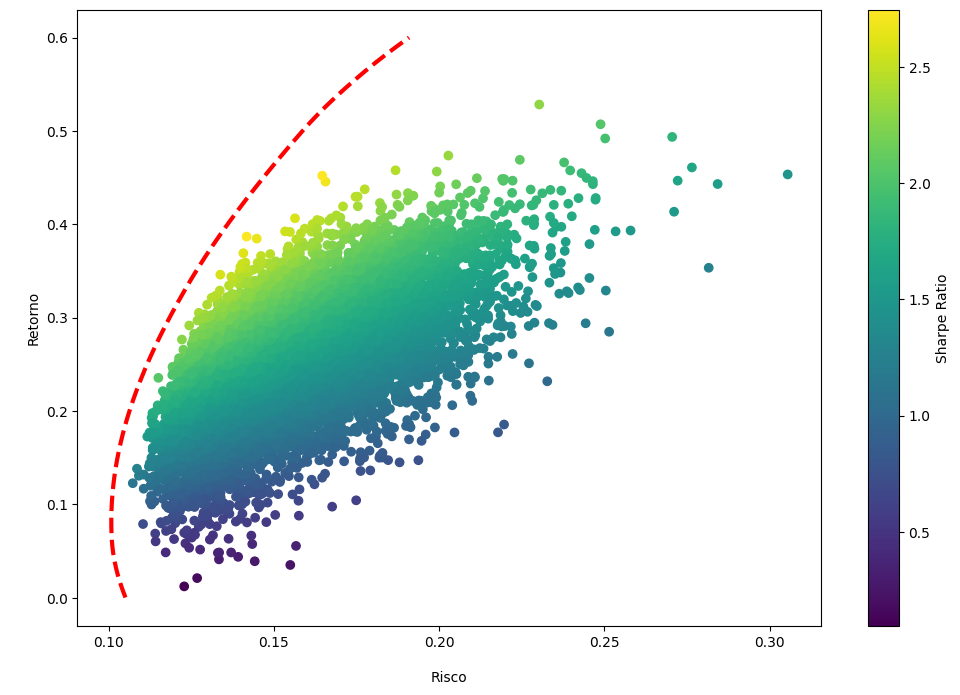

In [49]:
# Plot
plt.figure(figsize = (12,8))
plt.scatter(vol_arr, ret_arr, c = sharpe_arr, cmap = 'viridis')
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('\nRisco')
plt.ylabel('\nRetorno')
plt.plot(frontier_x, frontier_y, 'r--', linewidth = 3)
plt.show()

Conforme visto no gráfico acima, o retorno máximo que podemos obter é de cerca de 0,6 com um risco de cerca de 0,22 e o retorno mínimo que podemos obter é de cerca de 0,01 com um risco de cerca de 0,05.

Agora precisamos definir quanto alocar de cada asset financeiro em nosso portfólio para obter o maior retorno possível.

# Continuaremos no Próximo Capítulo

In [50]:
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [51]:
#%watermark -v -m

In [52]:
#%watermark --iversions

# Fim